In [18]:
#Import packages

#Rdkit
from rdkit import Chem

#Pandas
import pandas as pd
from pandas import DataFrame

#Others
import random
import numpy as np
import os
import math
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *

In [19]:
#AlvaDesc (If 'AlvaDesc' is not installed, load the corresponding csv file)
from alvadesccliwrapper.alvadesc import AlvaDesc
#AlvaDesc Path(Linux default alvaDescCLI location)
aDesc = AlvaDesc('./') 

In [41]:
def print_RxC(dataframe):
    rows= dataframe.shape[0]
    columns= dataframe.shape[1]
    rows_columns=print(dataframe.shape[0],"Moleculars ×",dataframe.shape[1],"Descriptors")
    return rows_columns
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='spearman')
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

In [42]:
#Setting the Work Path
warnings.filterwarnings ('ignore')
#Work Path
os.chdir(".\")

In [53]:
X_test_scaled=pd.read_csv("./Original data/X_test_data.csv",sep=',',index_col=0)
Pubchem_data=pd.read_csv("./Original data/Pubchem_data_clearn.csv",sep=',',index_col=0)
Predicted_data=pd.read_csv("./Results/LR_predict_data.csv",sep=',',index_col=0)
X_NAomit_data= pd.read_csv("./Original data/X_NAomit_data.csv",header=0,index_col=0)
Raw_data = pd.read_csv('./Original data/raw_data.csv',index_col=0)


In [133]:
Raw_all_data=X_NAomit_data[['ALOGP','ESOL','Hy','TPSA(Tot)']]
print_RxC(Raw_all_data)
Raw_all_data.head()

71 Moleculars × 4 Descriptors


,ALOGP,ESOL,Hy,TPSA(Tot)
ID,,,,
Ma_2019_A,-2.0201,-0.635691,3.098550,139.54
Ma_2019_U,-2.4504,0.193797,2.293407,124.78
Ma_2019_C,-2.4272,0.044637,3.232038,130.83
Ma_2019_G,-2.4107,-0.254351,4.009955,159.51
Ma_2019_dA,-1.2538,-1.136191,2.213815,119.31


In [134]:
#Scale data
Scaler = preprocessing.MinMaxScaler() #StandardScaler
Transformer =Scaler.fit(Raw_all_data)
X_scaled_data=Transformer.transform(Raw_all_data)
X_scaled_data =pd.DataFrame(X_scaled_data)
X_scaled_data.columns=Raw_all_data.columns
X_scaled_data.index=Raw_all_data.index
X_scaled_data['Hydrogel-forming ability']=Raw_data['Hydrogel-forming ability']
print_RxC(X_scaled_data)
X_scaled_data.head()

71 Moleculars × 5 Descriptors


,ALOGP,ESOL,Hy,TPSA(Tot),Hydrogel-forming ability
ID,,,,,
Ma_2019_A,0.117842,0.874849,0.443413,0.472652,Gelator
Ma_2019_U,0.078096,1.000000,0.286732,0.330770,Gelator
Ma_2019_C,0.080239,0.977495,0.469390,0.388926,Gelator
Ma_2019_G,0.081763,0.932384,0.620773,0.664616,Gelator
Ma_2019_dA,0.188622,0.799334,0.271243,0.278189,Gelator


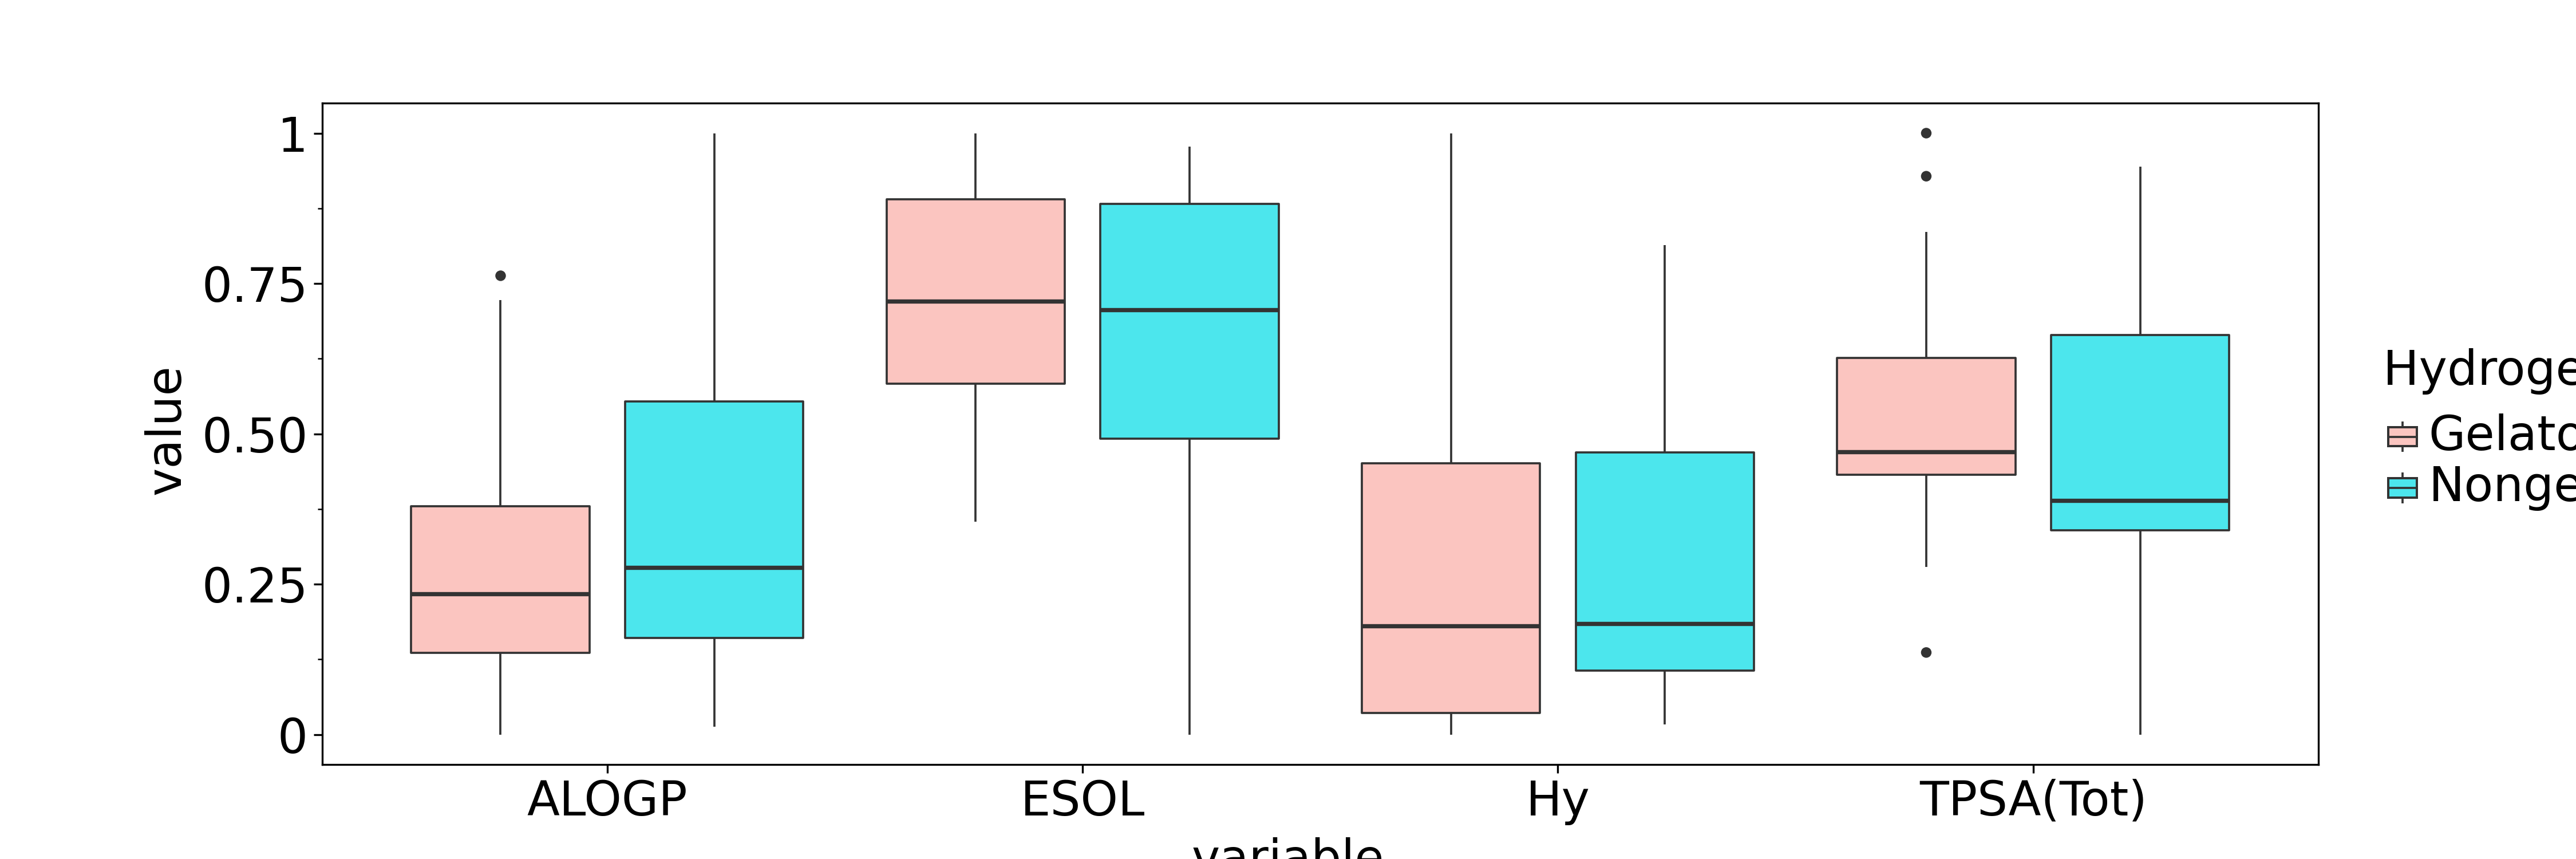

In [135]:
df=pd.melt(X_scaled_data,id_vars=['Hydrogel-forming ability'])
df["Descriptors"]=df["variable"]
df["Values"]=df["value"]
box2_plot=(ggplot(df, aes(x = "variable", y = "value"))
+ geom_boxplot(aes(fill="Hydrogel-forming ability"),position = position_dodge(0.9),size=0.5) 
+ guides(fill=guide_legend(title="Hydrogel-forming ability"))
+scale_fill_hue(s = 0.9, l = 0.85, h=0.05,color_space='husl')
+theme_matplotlib()
+theme(legend_position='right',
       text=element_text(size=20,colour = "black"),
       dpi=300,
       figure_size=(15,5)))
print(box2_plot)
box2_plot.save("./original figure/Figure 3a.svg", units="in", dpi=300)

In [136]:
Pubchem_data=Pubchem_data.loc[X_test_scaled.index.to_list()]
aDesc.set_input_SMILES(Pubchem_data['Canonical_smiles'].tolist())
if not aDesc.calculate_descriptors(['ALOGP','MLOGP','LOGP99','LOGPcons','ESOL','Hy','TPSA(NO)','TPSA(Tot)']):
 print('Error:' + aDesc.get_error())
else:
 Pubchem_descriptors=aDesc.get_output()

In [137]:
Pubchem_all_data=pd.concat([Pubchem_descriptor,Predicted_data['Probability of gelator']],axis=1)
Pubchem_all_data=Pubchem_all_data.sort_values('Probability of gelator', ascending=False)
Pubchem_gel_data=Pubchem_all_data.iloc[range(0,int(len(Pubchem_all_data)*0.1)),]
Pubchem_gel_data=Pubchem_gel_data.drop(['Probability of gelator'],axis=1)
Pubchem_gel_data.index.names=['ID']
Pubchem_gel_data['Probability of gelator']="Top 10%"
Pubchem_gel_data.to_csv("./Original data/Pubchem_gel_data.csv",sep=',',header=1,index=1)

In [138]:
# If 'AlvaDesc' is not installed, load the 'Pubchem_gel_data.csv' file
Pubchem_gel_data= pd.read_csv("./Original data/Pubchem_gel_data.csv",header=0,index_col=0)
print_RxC(Pubchem_gel_data)
Pubchem_gel_data.head()

725 Moleculars × 9 Descriptors


,ALOGP,MLOGP,LOGP99,LOGPcons,ESOL,Hy,TPSA(NO),TPSA(Tot),Probability of gelator
ID,,,,,,,,,
445132,-3.2962,-2.276331,-2.9891,-2.853877,0.285331,3.047842,182.93,192.74,Top 10%
92252368,-2.0988,-1.882651,-2.7198,-2.233750,0.128903,3.244100,157.64,157.64,Top 10%
21826754,-2.0988,-1.882651,-2.7198,-2.233750,0.128903,3.244100,157.64,157.64,Top 10%
131876227,-1.8929,-1.565443,-2.3776,-1.945314,-0.155452,2.245000,146.78,146.78,Top 10%
293725,-1.5960,-0.654957,-1.2234,-1.158119,-0.646246,1.296520,132.51,132.51,Top 10%


In [139]:
Raw_all_data=X_NAomit_data[['ALOGP','MLOGP','LOGP99','LOGPcons','ESOL','Hy','TPSA(NO)','TPSA(Tot)']]
Raw_all_data['Probability of gelator']=Raw_data['Hydrogel-forming ability']
Raw_gel_data=Raw_all_data.loc[Raw_all_data["Probability of gelator"] =='Gelator']
print_RxC(Raw_gel_data)
Raw_gel_data.head()

38 Moleculars × 9 Descriptors


,ALOGP,MLOGP,LOGP99,LOGPcons,ESOL,Hy,TPSA(NO),TPSA(Tot),Probability of gelator
ID,,,,,,,,,
Ma_2019_A,-2.0201,-0.345598,-1.9800,-1.448566,-0.635691,3.098550,139.54,139.54,Gelator
Ma_2019_U,-2.4504,-1.581610,-2.5091,-2.180370,0.193797,2.293407,124.78,124.78,Gelator
Ma_2019_C,-2.4272,-1.175610,-2.2681,-1.956970,0.044637,3.232038,130.83,130.83,Gelator
Ma_2019_G,-2.4107,-0.808423,-2.8158,-2.011641,-0.254351,4.009955,159.51,159.51,Gelator
Ma_2019_dA,-1.2538,0.393410,-0.9508,-0.603730,-1.136191,2.213815,119.31,119.31,Gelator


In [140]:
Concat_data=pd.concat([Pubchem_gel_data,Raw_gel_data])
print_RxC(Concat_data)
Concat_data.head()

763 Moleculars × 9 Descriptors


,ALOGP,MLOGP,LOGP99,LOGPcons,ESOL,Hy,TPSA(NO),TPSA(Tot),Probability of gelator
ID,,,,,,,,,
445132,-3.2962,-2.276331,-2.9891,-2.853877,0.285331,3.047842,182.93,192.74,Top 10%
92252368,-2.0988,-1.882651,-2.7198,-2.233750,0.128903,3.244100,157.64,157.64,Top 10%
21826754,-2.0988,-1.882651,-2.7198,-2.233750,0.128903,3.244100,157.64,157.64,Top 10%
131876227,-1.8929,-1.565443,-2.3776,-1.945314,-0.155452,2.245000,146.78,146.78,Top 10%
293725,-1.5960,-0.654957,-1.2234,-1.158119,-0.646246,1.296520,132.51,132.51,Top 10%


In [141]:
#Scale data
Concat_scale_data=Concat_data.drop(['Probability of gelator'],axis=1)
Scaler = preprocessing.MinMaxScaler() #StandardScaler
Transformer =Scaler.fit(Concat_scale_data)
X_scaled_data=Transformer.transform(Concat_scale_data)
X_scaled_data =pd.DataFrame(X_scaled_data)
X_scaled_data.columns=Concat_scale_data.columns
X_scaled_data.index=Concat_scale_data.index
X_scaled_data['Probability of gelator']=Concat_data['Probability of gelator']
print_RxC(X_scaled_data)
X_scaled_data.head()

763 Moleculars × 9 Descriptors


,ALOGP,MLOGP,LOGP99,LOGPcons,ESOL,Hy,TPSA(NO),TPSA(Tot),Probability of gelator
ID,,,,,,,,,
445132,0.120976,0.123701,0.164664,0.110432,0.855673,0.449902,0.707218,0.725518,Top 10%
92252368,0.248267,0.183944,0.197255,0.189625,0.825067,0.477743,0.535340,0.501880,Top 10%
21826754,0.248267,0.183944,0.197255,0.189625,0.825067,0.477743,0.535340,0.501880,Top 10%
131876227,0.270156,0.232484,0.238669,0.226459,0.769432,0.336013,0.461533,0.432686,Top 10%
293725,0.301718,0.371810,0.378354,0.326987,0.673406,0.201464,0.364551,0.341765,Top 10%


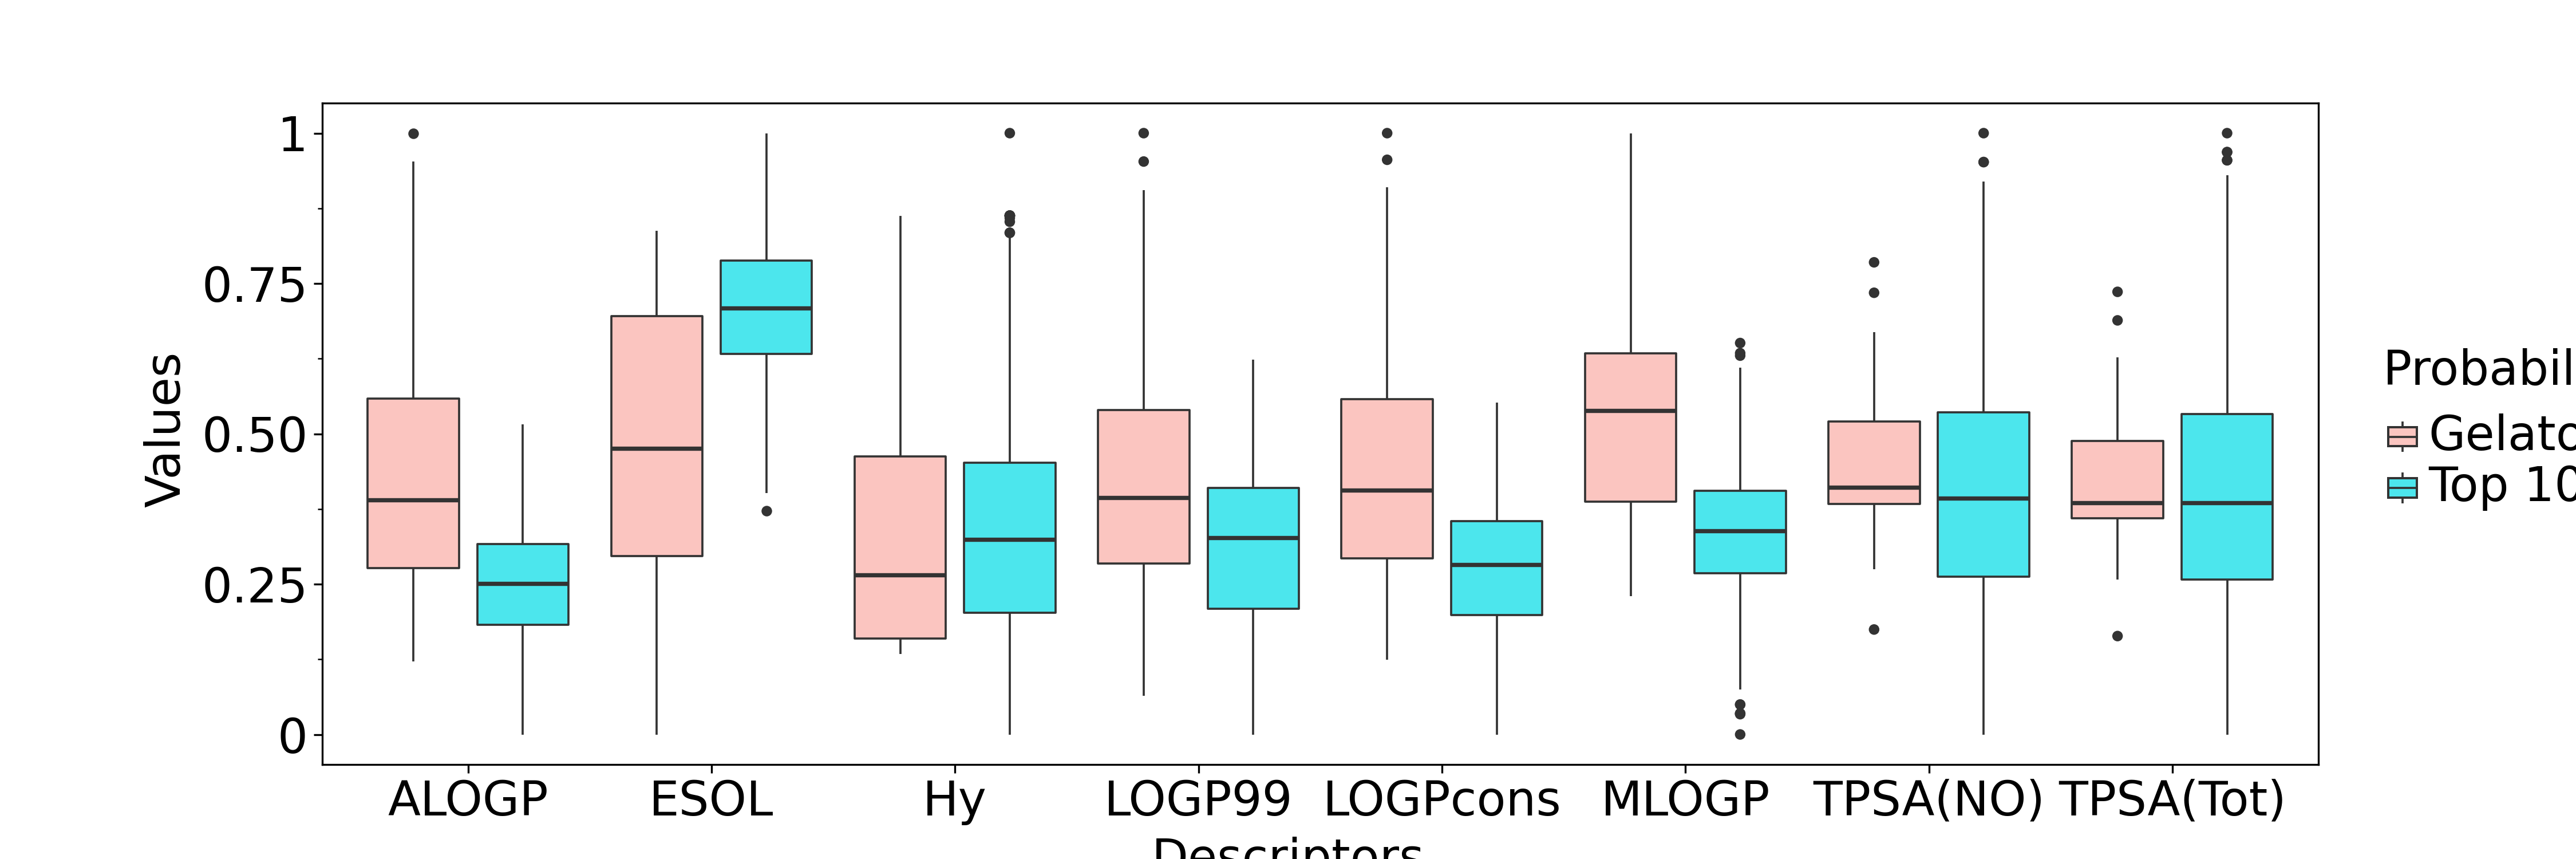

In [142]:
df=pd.melt(X_scaled_data,id_vars=['Probability of gelator'])
df["Descriptors"]=df["variable"]
df["Values"]=df["value"]
box2_plot=(ggplot(df, aes(x = "Descriptors", y = "Values"))
+ geom_boxplot(aes(fill="Probability of gelator"),position = position_dodge(0.9),size=0.5) 
+ guides(fill=guide_legend(title="Probability of gelator"))
+scale_fill_hue(s = 0.9, l = 0.85, h=0.05,color_space='husl')
+theme_matplotlib()
+theme(legend_position='right',
       text=element_text(size=20,colour = "black"),
       dpi=300,
       figure_size=(15,5)))
print(box2_plot)
box2_plot.save("./original figure/Figure S5.svg", units="in", dpi=300)

In [143]:
result=pd.read_csv("./Results/LR_predict_data.csv",sep=',')
result=pd.DataFrame(result)
result=result.sort_values(by=['Probability of gelator'],ascending=True)
result["rank"]=list(range(1,len(result)+1))
result

,cid,Probability of nongelator,Probability of gelator,rank
7256,84015621,0.764249,0.235751,1
7255,1838,0.759125,0.240875,2
7254,42553033,0.736183,0.263817,3
7253,42553032,0.736183,0.263817,4
7252,71832128,0.736183,0.263817,5
...,...,...,...,...
4,293725,0.340278,0.659722,7253
3,131876227,0.323628,0.676372,7254
2,21826754,0.319758,0.680242,7255
1,92252368,0.319758,0.680242,7256


In [144]:
resultX1=result.loc[result["cid"] ==135518164]
resultX2=result.loc[result["cid"] ==135763231]
resultX3=result.loc[result["cid"] ==135407175]

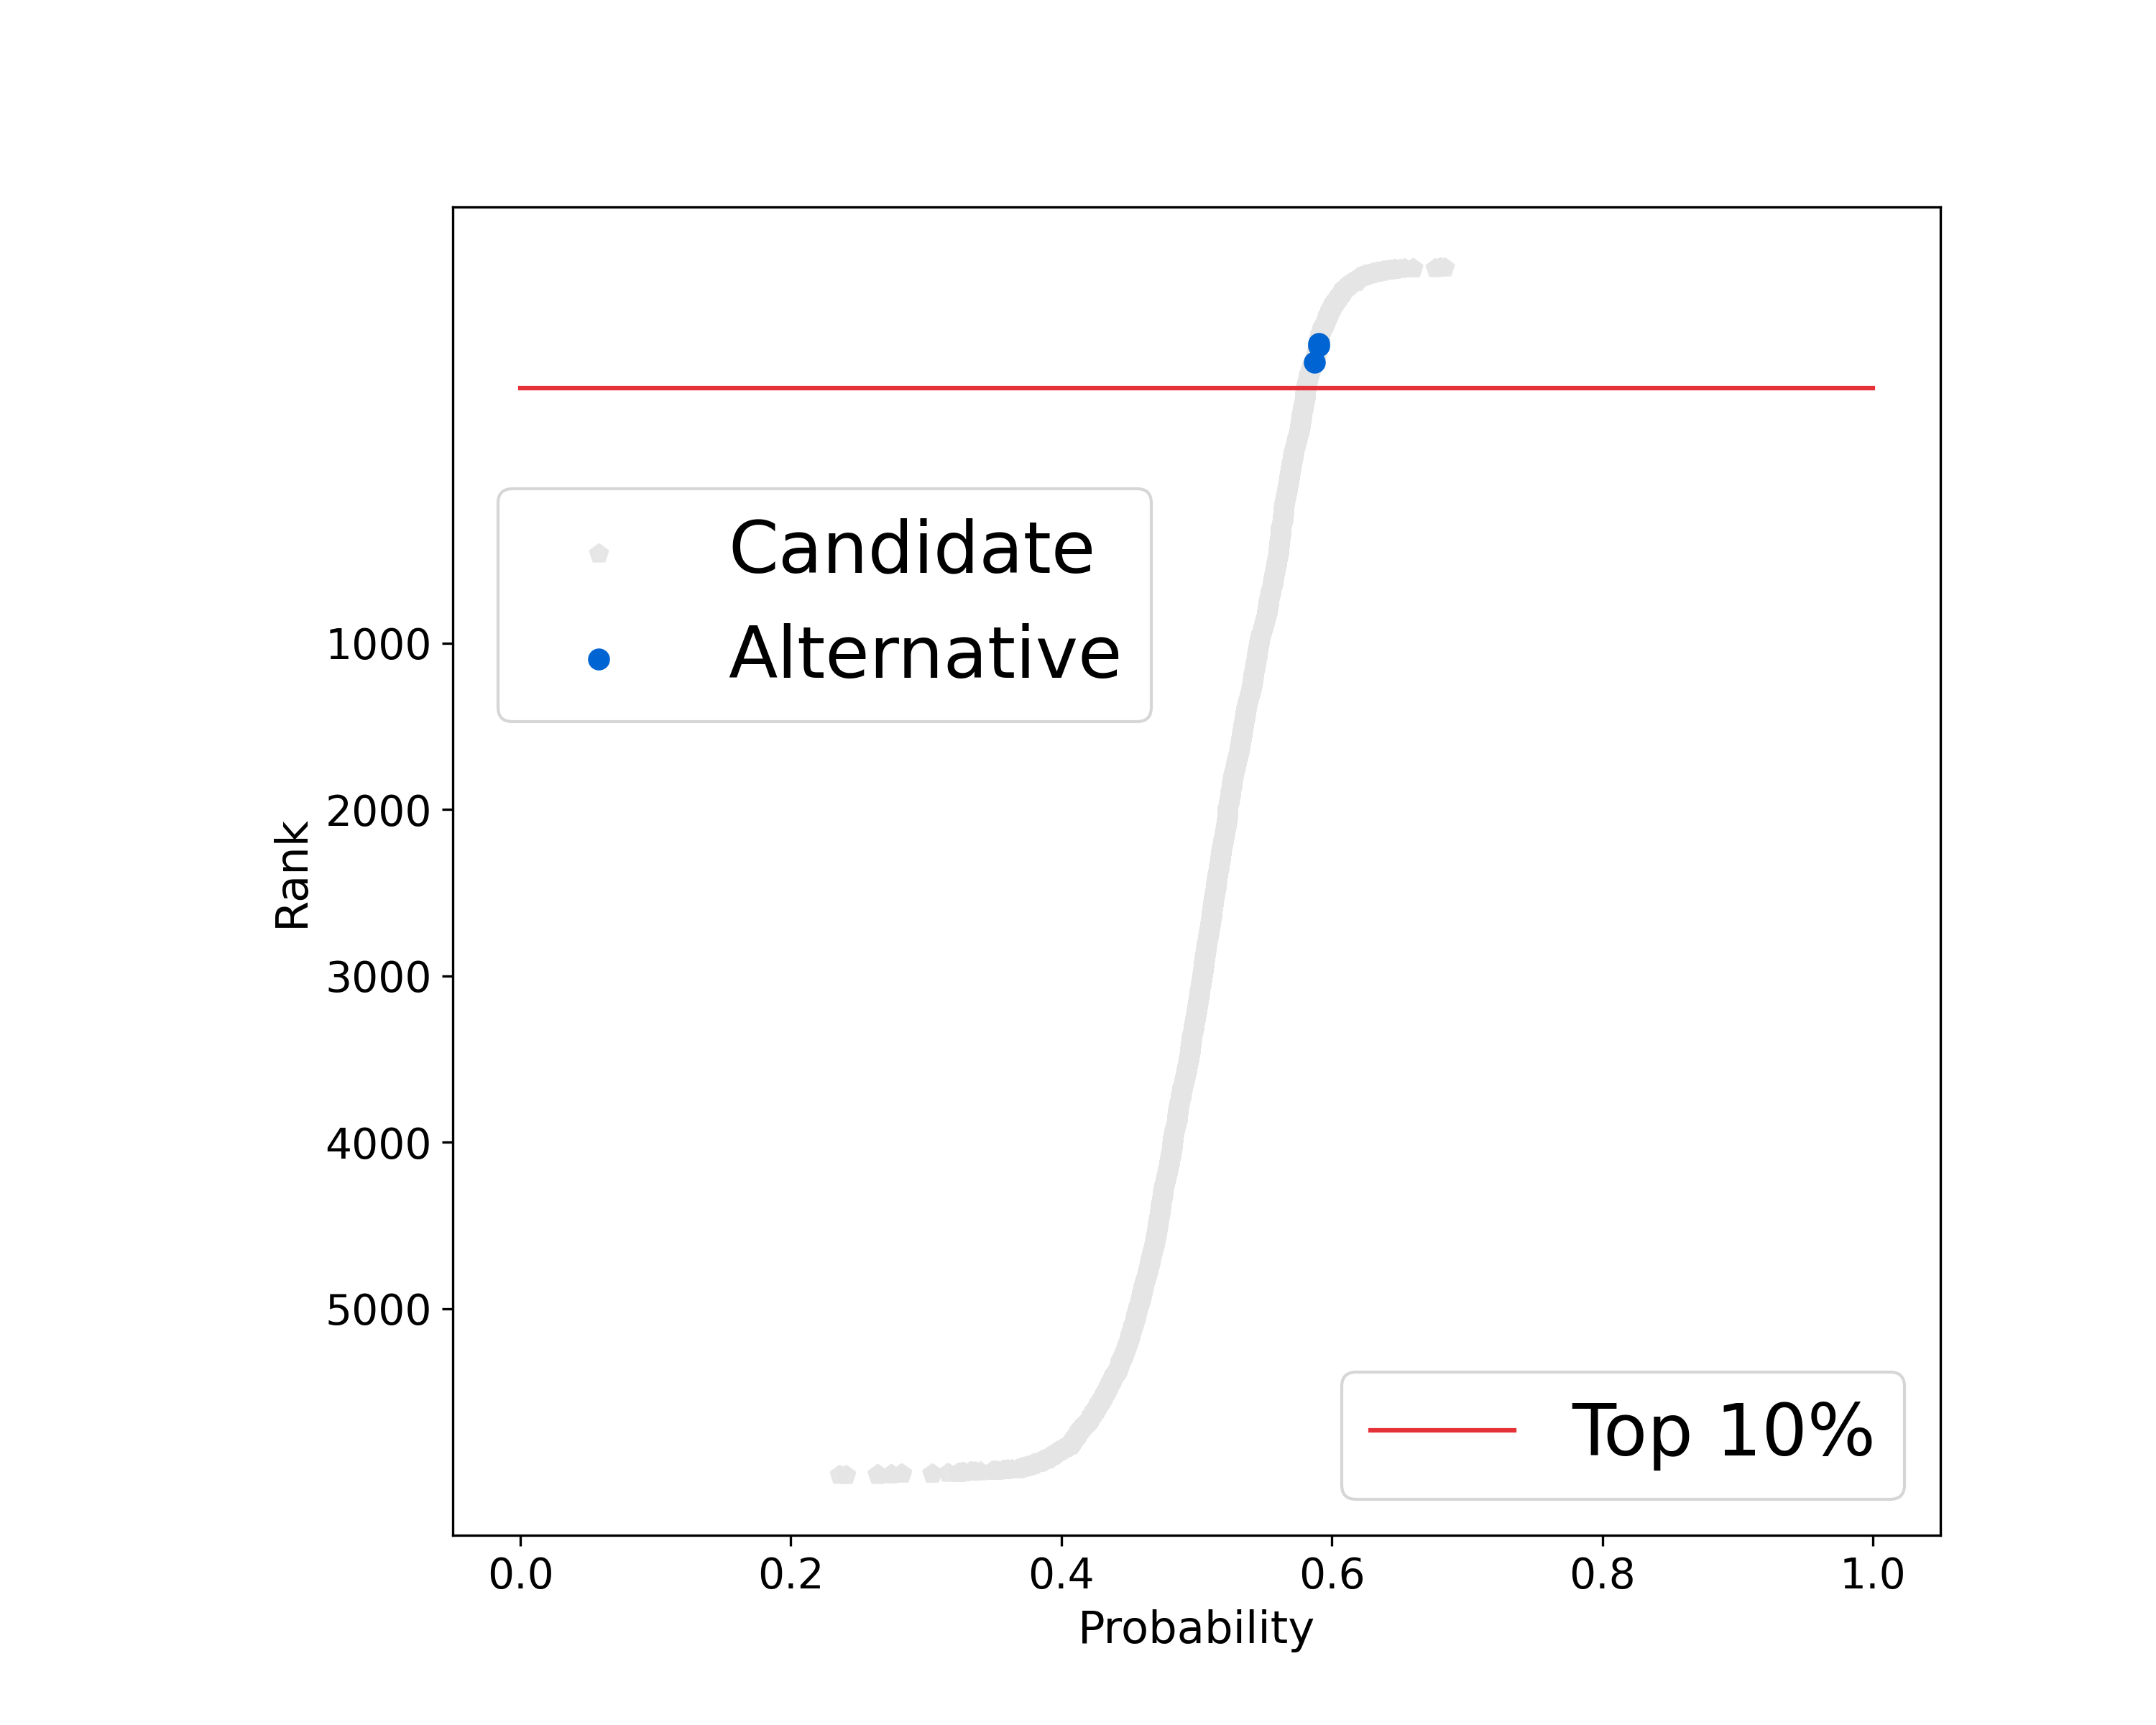

In [145]:
%matplotlib ipympl
plt.rcParams['figure.figsize'] = (10, 8) 
fig = plt.figure(1)
x = [0,1]
y = [len(result)*0.90,len(result)*0.90]
P=plt.plot(x,y,color='#e53238')
P1=plt.scatter(result['Probability of gelator'], result['rank'],  alpha=0.9, marker='p', color='#e5e5e5')
P2=plt.scatter(resultX1['Probability of gelator'],resultX1['rank'] ,  alpha=1, marker='o', color='#0064d2',s=40)
P3=plt.scatter(resultX2['Probability of gelator'],resultX2['rank'] ,  alpha=1, marker='o', color='#0064d2',s=40)
P4=plt.scatter(resultX3['Probability of gelator'],resultX3['rank'] ,  alpha=1, marker='o', color='#0064d2',s=40)
plt.xlabel('Probability',fontsize = 15)
yData = [1000, 2000, 3000,4000,5000]
yLim= ["5000","4000","3000","2000","1000"]
plt.yticks(yData,yLim)
plt.ylabel('Rank',fontsize = 15)
plt.tick_params(labelsize=14) 
l1=plt.legend(P, ['Top 10%'], loc="lower right",scatterpoints=1,fontsize='large')
l2=plt.legend([P1,P2], ['Candidate', 'Alternative'],bbox_to_anchor=(0.25,0.7),loc=10,scatterpoints=1,fontsize='large')
plt.gca().add_artist(l1)
plt.gcf().subplots_adjust(left=0.21)
plt.savefig("./original figure/Figure 3b.svg", dpi=300,format="svg")
plt.show()